In [1]:
# !pip install -q git+https://github.com/tensorflow/examples.git

## Segmentation
---
* <b>Model : MobileNetV2 </b><br>
    * BatchNormalization :
    * DepthWise :

In [1]:
import tensorflow as tf

tf.__version__

'2.0.0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output

import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [4]:
def normalize(input_image, input_mask):
    # Change data shape
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # Subtract mask to -1  {1,2,3} --> {0,1,2}
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'],(128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128))
    
    #filp data randomly
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask
    
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [78]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.0.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    urls=['http://www.robots.ox.ac.uk/~vgg/data/pets/'],
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Jawahar, C.~V.",
      title        = "Cats and Dogs",
      booktitle    =

In [76]:
# TRAIN_LENGTH = 3680
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = 57
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [77]:
print(TRAIN_LENGTH,STEPS_PER_EPOCH)

3680 57


In [45]:
dataset['train'].map(load_image_train)

<MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [6]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [7]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [79]:
type(train)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [59]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='brg')
        plt.axis('off')
    plt.show()

In [61]:
test.take(0)

<TakeDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

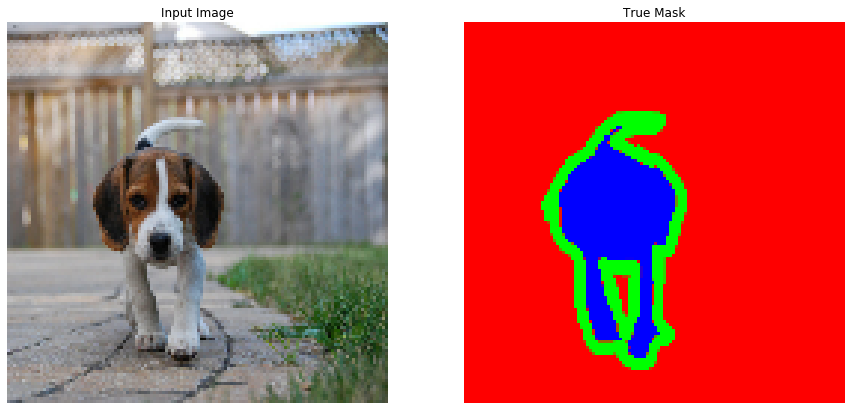

In [64]:
for image, mask in test.take(5):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [63]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [83]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [85]:
layers

[<tf.Tensor 'block_1_expand_relu_1/Identity:0' shape=(None, 64, 64, 96) dtype=float32>,
 <tf.Tensor 'block_3_expand_relu_1/Identity:0' shape=(None, 32, 32, 144) dtype=float32>,
 <tf.Tensor 'block_6_expand_relu_1/Identity:0' shape=(None, 16, 16, 192) dtype=float32>,
 <tf.Tensor 'block_13_expand_relu_1/Identity:0' shape=(None, 8, 8, 576) dtype=float32>,
 <tf.Tensor 'block_16_project_1/Identity:0' shape=(None, 4, 4, 320) dtype=float32>]

In [14]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [18]:
def unet_model(output_channels):

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
    output_channels, 3, strides=2,
    padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

  # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [21]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [27]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

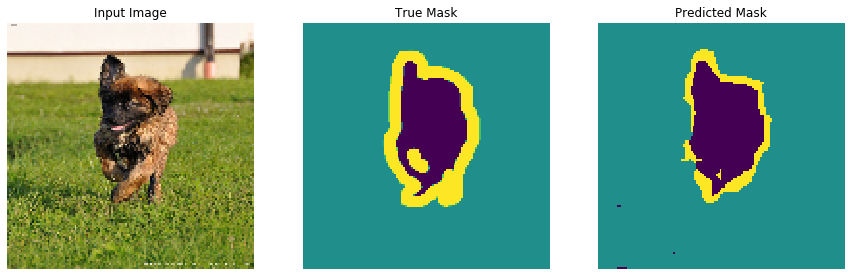

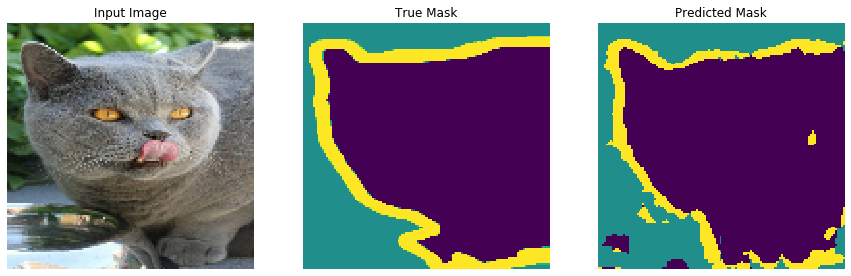

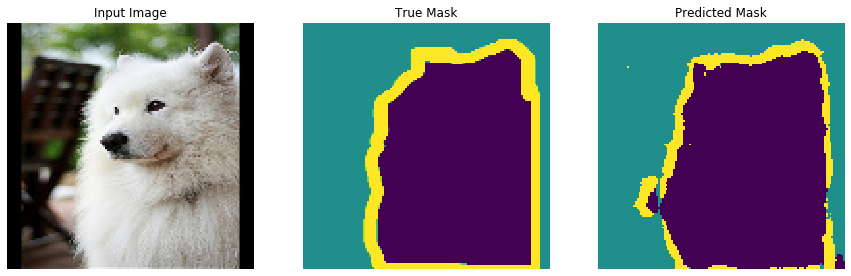

In [41]:
show_predictions(test_dataset,3)

In [29]:
# class DisplayCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
#         show_predictions()
#         print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [37]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)
# ,
#                           callbacks=[DisplayCallback()])

Train for 57 steps, validate for 11 steps
Epoch 1/20
57/57 [==============================] - 12s 207ms/step - loss: 0.1307 - accuracy: 0.9401 - val_loss: 0.3711 - val_accuracy: 0.8789
Epoch 2/20
57/57 [==============================] - 12s 207ms/step - loss: 0.1260 - accuracy: 0.9421 - val_loss: 0.4016 - val_accuracy: 0.8740
Epoch 3/20
57/57 [==============================] - 12s 205ms/step - loss: 0.1242 - accuracy: 0.9427 - val_loss: 0.3773 - val_accuracy: 0.8780
Epoch 4/20
57/57 [==============================] - 12s 206ms/step - loss: 0.1198 - accuracy: 0.9445 - val_loss: 0.4067 - val_accuracy: 0.8782
Epoch 5/20
57/57 [==============================] - 12s 206ms/step - loss: 0.1148 - accuracy: 0.9466 - val_loss: 0.4111 - val_accuracy: 0.8749
Epoch 6/20
57/57 [==============================] - 12s 206ms/step - loss: 0.1119 - accuracy: 0.9478 - val_loss: 0.4279 - val_accuracy: 0.8727
Epoch 7/20
57/57 [==============================] - 12s 206ms/step - loss: 0.1123 - accuracy: 0.9476

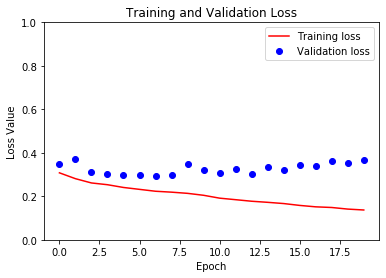

In [33]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

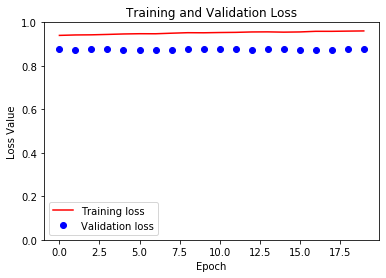

In [38]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, accuracy, 'r', label='Training loss')
plt.plot(epochs, val_accuracy, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [35]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])